### Start

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
!pip install tqdm

### Imports

In [ ]:
import re
import os
import json
import math
import random
import time
import tarfile
import random
import numpy as np
from datetime import datetime
from typing import Optional
from collections import Counter
from configparser import ConfigParser
from typing import List, Dict, Tuple, Optional, Union

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torch import Tensor

# from tqdm.auto import tqdm, trange

import logging
import tarfile
# from tqdm import tqdm


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import tqdm.notebook as tqdm
import torch.utils.data as torch_data
import torchaudio
from sklearn.metrics import balanced_accuracy_score

from IPython.display import clear_output

%matplotlib inline



### Служебные

In [ ]:
def get_date_id():
    now = datetime.now()
    date_id = now.strftime("%Y%m%d_%H%M%S")
    return date_id


# def save_submission(submission:List, save_dir:str):
#   os.makedirs(save_dir, exist_ok=True)
#   filename = os.path.join(f"submission_{get_date_id()}.txt")
#   with open(os.path.join(save_dir, filename), "w") as f:
#       for line in submission:
#           f.write("{}\n".format(" ".join(list(map(str, map(int, line))))))

def save_submission(submission:List[dict], save_dir:str):
    os.makedirs(save_dir, exist_ok=True)
    filename = os.path.join(f"submission_{get_date_id()}.jsonl")
    with open(os.path.join(save_dir, filename), "w", encoding="utf-8") as f:
        for di in submission:
            line = json.dumps(di, sort_keys=True, ensure_ascii=False, separators=(',', ':'))
            f.write(line+"\n")

def save_models(model:nn.Module, optimizer, model_name:str, save_dir:str):
    os.makedirs(save_dir, exist_ok=True)
    filename = os.path.join(f"{model_name}_{get_date_id()}.pt")
    try:
        # torch.save(model.state_dict(), os.path.join(save_dir, filename))
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            # 'scheduler_step_dict': scheduler.state_dict()
            }, os.path.join(save_dir, filename))
    except Exception as e:
        print(f"ошибка в сохранении модели {e}")

def load_weights(model:nn.Module, path:str, device:torch.device):
    if os.path.exists(path):
        model.load_state_dict(torch.load(path, map_location=device, weights_only=True))
        print(f"Модель успешно загружена из {path}")
    else:
        print("Путь модели не существует!")


def load_config(path: str) ->ConfigParser:
    try:
        config = ConfigParser()
        config.read(path)
        return config
    except Exception as e:
        print(f"ошибка чтения конфига {e}")



In [ ]:
root = "/content/drive/MyDrive/nlp_train_contests/2/"
temp_dir = "/content/sample_data/"
data_dir = os.path.join(temp_dir, "data")
os.makedirs(data_dir, exist_ok=True)
zip_path = os.path.join(root, "data", "ml_trains.tar.gz")

DATADIR = os.path.join(data_dir, 'ml_trains_data')
models_dir = os.path.join(root, "models")
noise_dir = os.path.join(root, "noises")
log_dir = os.path.join(root, "log")
LOADER_WORKERS = 0

DEVICE = torch.device("cuda:0")

In [ ]:
print(data_dir)
print(zip_path)
print(DATADIR)

/content/sample_data/data
/content/drive/MyDrive/nlp_train_contests/2/data/ml_trains.tar.gz
/content/sample_data/data/ml_trains_data


In [ ]:
def save_logs(log_file, log_dir, epoch, lr, train_loss, train_acc, val_loss, val_acc):
    with open(os.path.join(log_dir, log_file), "a") as lf:
        lf.write(f'Datetime {get_date_id()}.\n')
        lf.write(f'Epoch {epoch + 1}.\n')
        lf.write(f'lr = {lr} \n')
        lf.write(f'Train loss {train_loss}. Train accuracy {train_acc}.\n')
        lf.write(f'Test loss {val_loss}. Test accuracy {val_acc}\n')

In [ ]:
# ## Для добавления файлов с Яндекс.Диска
# import requests
# public_key = ''
# final_url = f"https://cloud-api.yandex.net/v1/disk/public/resources/download?public_key={public_key}"
# response = requests.get(final_url)
# download_url = response.json()['href']
# response = requests.get(download_url)
# # Имя файла

# with open(dist_path, 'wb') as f:
#     f.write(response.content)


In [ ]:
from tqdm import tqdm
with tarfile.open(zip_path) as tar:
    for mem in tqdm(iterable=tar.getmembers(), total=len(tar.getmembers())):
        try:
            tar.extract(mem, data_dir)
            # print(member)
        except Exception as e:
            print("Extracting error:", e)
            pass

100%|██████████| 58434/58434 [01:41<00:00, 574.44it/s]


In [ ]:
import tqdm.notebook as tqdm

### Отрисовка

In [ ]:
import librosa
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)

In [ ]:
# DEVICE = 'cpu' # also you can use "cuda" for gpu and "mps" for apple silicon

### Аугментация

In [ ]:
def random_mask_area(sound: torch.tensor):
    """волна [1, shape]"""
    total_l = sound.shape[1]
    mask = torch.ones(size=(total_l,))
    for i in range(random.randint(2, 5)):
        area_l = total_l // random.randint(15, 35)
        pos = random.randint(0, total_l - area_l)
        mask[pos:pos + area_l] = 0
    mask = mask.unsqueeze(0)
    return sound[:, ]*mask

def take_random_part(sound: torch.tensor):
    """волна [1, shape]"""
    total_l = sound.shape[1]
    area_l = int(total_l / (random.randint(12, 18)/10))
    pos = random.randint(0, total_l - area_l)
    crop = sound[:, pos:pos+area_l]
    crop=crop.repeat_interleave(2)
    crop_len=crop.shape[0]
    start=random.randint(0, crop_len-total_l-1)
    crop=crop[start:start+total_l]
    #print(f"crop success with {crop.shape}")
    return crop.unsqueeze(0)#  пока заглушка


def add_random_noise(signal):
    """Случайный шум из папки"""
    coef=(random.random()+1)/20.
    noise_file = random.choice(os.listdir(noise_dir))
    noise_path = os.path.join(noise_dir, noise_file)
    noise, _ = torchaudio.load(noise_path, normalize=True)
    min_len=min(signal.shape[-1], noise.shape[-1])
    new_signal = signal[:, :min_len] + noise[:, :min_len] * coef
    return new_signal / torch.max(torch.abs(new_signal))

def dummy(signal):
    '''ничего не делает'''
    return signal

def add_gauss(spec):
    """Добавляет нормальный шум к спектрограмме"""
    gauss = torch.normal(0, 7, size = spec.shape)
    return gauss+spec

### Встроенный датасет

In [ ]:
class Dataset(torch_data.Dataset):
    def __init__(self, split_part: str, datadir: str, feats: nn.Module, read_labels=True):
        super().__init__()
        self.split_part=split_part
        data = pd.read_csv(os.path.join(datadir, f'{split_part}.tsv'), sep='\t')
        if read_labels:
            labels = {key: idx for idx, key in enumerate(sorted(set(data.label.values)))}
            self._idx_to_label = {idx: key for idx, key in enumerate(sorted(set(data.label.values)))}
            self._classes = len(labels)
        else:
            self._classes = 30

        self.lst = [0, 1,2,3,4]
        self.funcs =[dummy, add_gauss, random_mask_area, take_random_part, add_random_noise]
        self.probs = [0.6, 0.15, 0.15, 0.05, 0.05] #[0.65, 0.15, 0.1, 0.03, 0.02] | [0.45, 0.3, 0.15, 0.05, 0.05]

        self._feats = feats
        self._ytids = []
        self._pathes = []
        self._labels = []
        for _, row in data.iterrows():
            path = os.path.join(datadir, 'clips', f'{row.YTID}.flac')
            if os.path.exists(path):
                self._ytids.append(row.YTID)
                self._pathes.append(path)
                self._labels.append(labels[row.label] if read_labels else 0)
        #print(self._labels)
        self._df = pd.DataFrame([[y, p, c] for y, p, c in zip(self._ytids, self._pathes, self._labels)], columns=['YTID', 'path', 'code'])
        #print(self._df)
    def __getitem__(self, index):
        try:

            anchor_path = self._pathes[index]
            anchor_lab = self._labels[index]
            anchor_waveform, sample_rate = torchaudio.load(self._pathes[index])
            if self.split_part!="eval":
                # pos_path=random.choice(self._df.loc[self._df.code==anchor_lab, "path"].to_list())
                # neg_path=random.choice(self._df.loc[self._df.code!=anchor_lab, "path"].to_list())
                pos_path=self._df.loc[self._df.code==anchor_lab, :].sample()["path"].to_list()[0]
                neg_path=self._df.loc[self._df.code!=anchor_lab, :].sample()["path"].to_list()[0]

                pos_waveform, _ = torchaudio.load(pos_path)
                neg_waveform, _ = torchaudio.load(neg_path)
        except Exception as err:
            logging.error("Can't read file %s", self._pathes[index])
            raise err
        assert sample_rate == 16000
        assert anchor_waveform.shape[0] == 1
        """ТУТ АУГМЕНТАЦИЯ"""
        anchor_rand = np.random.choice(self.lst, p=self.probs)
        pos_rand = np.random.choice(self.lst, p=self.probs)
        neg_rand = np.random.choice(self.lst, p=self.probs)
        #print(f"a={anchor_rand}, p={pos_rand}, n={neg_rand}")
        if self.split_part=="train":
            # Если рандом больше 1, то применяем соответствующую аугментацию
            if anchor_rand>1:
                anchor_waveform = self.funcs[anchor_rand](anchor_waveform)
            if pos_rand>1:
                pos_waveform = self.funcs[pos_rand](pos_waveform)
            if neg_rand>1:
                neg_waveform = self.funcs[neg_rand](neg_waveform)
        #    randomizer = random.random()
        #    if randomizer>0.95:
        #        coef=(random.random()+1)/20.
        #        anchor_waveform = add_random_noise(anchor_waveform, coef=coef)
        #        if self.split_part!="eval":
        #            pos_waveform = add_random_noise(pos_waveform, coef=coef)
        #    elif randomizer>0.65:
        #        anchor_waveform = random_mask_area(anchor_waveform)
        #        if self.split_part!="eval":
        #            pos_waveform = random_mask_area(pos_waveform)
        #    elif randomizer>0.6:
        #        anchor_waveform = take_random_part(anchor_waveform)
        #        if self.split_part!="eval":
        #            pos_waveform = take_random_part(pos_waveform)


        #anchor_feats = self._feats(anchor_waveform)[0]
        #if self.split_part!="eval":
        #    pos_feats = self._feats(pos_waveform)[0]
        #    neg_feats = self._feats(neg_waveform)[0]
        anchor_feats = self._feats(anchor_waveform)[0]
        if anchor_rand==1:
            anchor_feats=add_gauss(anchor_feats)
        if self.split_part!="eval":
            pos_feats = self._feats(pos_waveform)[0]
            if pos_rand==1:
                pos_feats=add_gauss(pos_feats)
            neg_feats = self._feats(neg_waveform)[0]
            if neg_rand==1:
                neg_feats=add_gauss(neg_feats)
        else:
            pos_feats = torch.zeros_like(anchor_feats)
            neg_feats = torch.zeros_like(anchor_feats)
        #return (anchor_feats, pos_feats, neg_feats, self._labels[index])
        # Для эвала остальные значения вернуть torch.empty(0)
        return {'anchor':anchor_feats,
                    'pos':pos_feats,
                    'neg':neg_feats,
                    'label':self._labels[index]}
    def __len__(self) -> int:
        return len(self._pathes)

    def classes(self) -> int:
        return self._classes


def collate_fn(batch):
    '''функция пакетирования с учетом триплет-лосса'''
    max_length = max(max(item['anchor'].shape[1], item['pos'].shape[1], item['neg'].shape[1]) for item in batch)
    A = torch.zeros((len(batch), batch[0]['anchor'].shape[0], max_length))
    P = torch.zeros((len(batch), batch[0]['pos'].shape[0], max_length))
    N = torch.zeros((len(batch), batch[0]['neg'].shape[0], max_length))
    for idx, item in enumerate(batch):
        A[idx, :, :item['anchor'].shape[1]] = item['anchor']
        P[idx, :, :item['pos'].shape[1]]=item['pos']
        N[idx, :, :item['neg'].shape[1]]=item['neg']
    targets = torch.tensor([item['label'] for item in batch], dtype=torch.long).reshape(len(batch), 1)
    return {'anchor':A, 'pos':P, 'neg':N, 'targets':targets}

In [ ]:
class LogMelSpectrogram(nn.Module):
    pass

# FBANK 40 by default, but you can choose something else
FEATS = 128
transform = nn.Sequential(torchaudio.transforms.MelSpectrogram(n_mels=FEATS, n_fft=2048), #было n_mels=64, n_fft=400
                          torchaudio.transforms.AmplitudeToDB())
#transform = torchaudio.transforms.MelSpectrogram(n_mels=FEATS, n_fft=2048)
trainset = Dataset('train', DATADIR, transform)
testset = Dataset('eval', DATADIR, transform, read_labels=False)
N_CLASSES = trainset.classes()
assert N_CLASSES == 30
trainset[0]

{'anchor': tensor([[ 18.2911,  35.1760,  17.0199,  ...,  -1.0997,   1.5909,  21.8976],
         [ 31.5711,  38.0578,  28.6392,  ..., -12.5369,  -7.1074,   7.6186],
         [ 39.9738,  56.8177,  23.2289,  ..., -13.2888,  15.6333,  12.0010],
         ...,
         [ 15.5628,  17.0883,  39.9133,  ...,  -4.2603,   1.1119,  -8.3726],
         [ -4.2786,  27.4492,  27.6823,  ...,   2.5422,  -1.9686,  11.3948],
         [  5.6874,   4.6864,  13.1684,  ...,  -6.1780,   2.9257,  -3.7510]]),
 'pos': tensor([[ 23.3739,  23.5960,  19.0726,  ...,  18.6210,  17.2988,  15.5835],
         [ 24.9059,  16.0390,   5.2711,  ...,  12.1492,  11.0632,  12.1829],
         [ 28.8230,  19.5068,  14.3272,  ...,  15.3315,  16.7118,  12.6198],
         ...,
         [  1.9091,   4.1749,  -2.4452,  ...,  -5.2159,   3.6184,   0.2225],
         [ -0.2515,  -1.2884,  -7.6011,  ...,  -9.0397,   0.5807,  -5.5225],
         [  1.8812,  -1.6659, -11.1594,  ..., -11.3550,  -4.4619,  -9.8397]]),
 'neg': tensor([[  2.9292, 

In [ ]:
def balanced_accuracy(items: list[tuple[int, int]], classes=N_CLASSES) -> float:
    targets = np.array([el[0] for el in items], dtype = np.int16)
    preds = np.array([el[1] for el in items], dtype = np.int16)
    BAcc = balanced_accuracy_score(targets, preds)
    return BAcc

In [ ]:
assert np.isclose(balanced_accuracy([(0, 0), (0, 0), (1, 1)], 2), 1.0)
assert np.isclose(balanced_accuracy([(0, 1), (1, 0)], 2), 0.0)
assert np.isclose(balanced_accuracy([(0, 0), (0, 0), (1, 0)], 2), 0.5)
assert np.isclose(balanced_accuracy([(0, 0), (1, 1), (0, 0), (0, 0), (1, 0), (0, 1)], 2), 0.625)
assert np.isclose(balanced_accuracy([(1, 1), (0, 1), (2, 2)], 3), 0.66666666666666)

In [ ]:
import sklearn
data = pd.read_csv(os.path.join(DATADIR, f'train.tsv'), sep='\t')

data['code'] = data.label.astype('category').cat.codes
# print(data)
y = data["code"]
y = y.to_numpy()
class_weights=sklearn.utils.class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(y), y= y)
# print(class_weights)

### Встроенный трейн

In [ ]:
def batch_distance(x, y):
    return 1.0 - F.cosine_similarity(x, y)


loss_1 = nn.CrossEntropyLoss(weight=torch.from_numpy(class_weights).to(DEVICE).float(),reduction='mean')
loss_2 = nn.TripletMarginWithDistanceLoss(distance_function=lambda x, y: 1.0- F.cosine_similarity(x, y),
                                        margin=0.7)

def stage(
    model: nn.Module,
    data: torch_data.Dataset,
    opt: torch.optim.Optimizer,
    scheduler,
    batch_size: int = 256,
    train: bool = True
):
    loader = torch_data.DataLoader(
        data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=LOADER_WORKERS,
        collate_fn=collate_fn
    )
    if train:
        model.train()
    else:
        model.eval()
    loss_sum, batches = 0.0, 0
    pred_pairs = []
    for batched in tqdm.tqdm(loader):
        A = batched['anchor']
        P = batched['pos']
        N = batched['neg']
        Y = batched['targets']
        pred_anchor = model.forward(A.to(DEVICE))
        pred_pos = model.forward(P.to(DEVICE))
        pred_neg = model.forward(N.to(DEVICE))
        #print(pred_anchor.shape)
        #print(pred_anchor.squeeze().shape)

        # идея неверная!
        # distances_neg = batch_distance(pred_anchor, pred_neg)
        # max_neg_idx = torch.argmax(distances_neg).item()
        # pred_neg_most = (torch.ones_like(pred_neg)*pred_neg[max_neg_idx]).to(DEVICE)

        l1 = loss_1(pred_anchor.squeeze(), Y.squeeze().to(DEVICE))
        l2 = loss_2(pred_anchor.squeeze(), pred_pos.squeeze(), pred_neg.squeeze())
        loss = l1+l2
        if train:
            opt.zero_grad()
            loss.backward()
            opt.step()
        else:
            scheduler.step()
        loss_sum += loss.item()
        batches += 1
        with torch.no_grad():
            pred_pairs.extend(zip(
                Y.data.numpy().reshape(-1),
                torch.argmax(pred_anchor, dim=1).cpu().data.numpy().reshape(-1)
            ))
    return loss_sum / batches, balanced_accuracy(pred_pairs)


def train(
    model: nn.Module,
    opt,
    scheduler,
    batch_size: int = 256,
    epochs: int = 10,
):
    train_data, val_data = torch.utils.data.random_split(trainset, (0.99, 0.01), generator=torch.Generator().manual_seed(42))
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    for epoch_idx, epoch in enumerate(range(epochs)):
        train_loss, train_acc = stage(model, train_data, opt, scheduler, batch_size=batch_size)
        val_data.dataset.split_part="val"
        val_loss, val_acc = stage(model, val_data, opt, scheduler, batch_size=batch_size, train=False)
        train_data.dataset.split_part="train"
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        clear_output()
        fig, axis = plt.subplots(1, 2, figsize=(15, 7))
        axis[0].plot(np.arange(1, epoch + 2), train_losses, label='train')
        axis[0].plot(np.arange(1, epoch + 2), val_losses, label='val')
        axis[1].plot(np.arange(1, epoch + 2), train_accs, label='train')
        axis[1].plot(np.arange(1, epoch + 2), val_accs, label='val')
        axis[0].set(xlabel='epoch', ylabel='CE Loss')
        axis[1].set(xlabel='epoch', ylabel='Accuracy')
        fig.legend()
        plt.show()
        print(f'Epoch {epoch + 1}.')
        print(f'Train loss {train_loss}. Train accuracy {train_acc}.')
        print(f'Test loss {val_loss}. Test accuracy {val_acc}')
        # opt.param_groups[0]["lr"]
        save_logs("log.txt", log_dir, epoch, scheduler.get_lr(), train_loss, train_acc, val_loss, val_acc)
        if (epoch_idx+1)%1==0:
            save_models(model, model_name = "triplet_resnet", optimizer = opt, save_dir = models_dir)

### ResNet18 без последнего блока

In [ ]:
#import torch.nn as nn
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out
class MyResNet18(nn.Module):
    def __init__(self, num_classes=30):
        super(MyResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        #self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        #self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)
    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)
    def forward(self, x):
        x=x.unsqueeze(1)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        #out = self.layer3(out)
        #out = self.layer4(out)

        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


In [ ]:
model = MyResNet18()
print(model)
print(sum([p.numel() for p in model.parameters()]))

MyResNet18(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


### Проверки

In [ ]:
train_data, val_data = torch.utils.data.random_split(trainset, (0.9, 0.1), generator=torch.Generator().manual_seed(42))
val_data.dataset.split_part="train"
loader = torch_data.DataLoader(
        val_data,
        batch_size=4,
        shuffle=True,
        num_workers=LOADER_WORKERS,
        collate_fn=collate_fn
    )

tensor([[17],
        [ 9],
        [23],
        [20]])


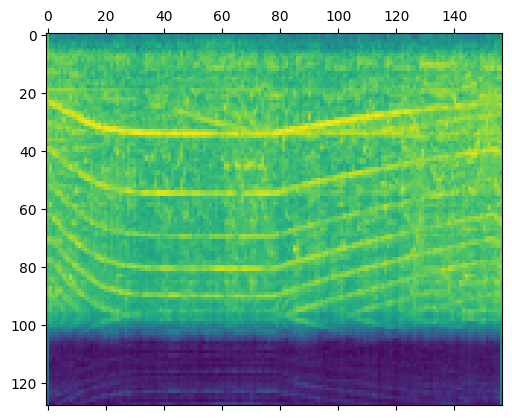

In [ ]:
print(next(iter(loader))['targets'])
img = next(iter(loader))['anchor'][0]
plt.matshow(img)

In [ ]:
model = MyResNet18()
model(next(iter(loader))['anchor']).shape

torch.Size([4, 30])

### Трейн

In [ ]:
torch.cuda.empty_cache()

model = MyResNet18().to(DEVICE)
# print(model.parameters())

opt = torch.optim.Adam(model.parameters(), lr=0.01, foreach=False)
scheduler =torch.optim.lr_scheduler.PolynomialLR(opt, 21*60) #lr меняем на последний полученный
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=200)

# checkpoint = torch.load(os.path.join(models_dir, "triplet_resnet__20241128_123130.pt"), weights_only=True, map_location=DEVICE)
# model.load_state_dict(checkpoint["model_state_dict"])
# opt.load_state_dict(checkpoint["optimizer_state_dict"])

train(model, opt, scheduler, batch_size=64, epochs = 40)

### Eval

In [ ]:
os.makedirs(os.path.join(root, "results"), exist_ok=True)

In [ ]:
result = []
for idx, ytid in enumerate(tqdm.tqdm(testset._ytids)):
    model.eval()
    with torch.no_grad():
        testdict = testset[idx]
        feats = testdict['anchor']
        pred_anchor = model.forward(feats.unsqueeze(0).to(DEVICE))
        predict = torch.argmax(pred_anchor, dim=1).cpu().data.numpy().reshape(-1)[0]
        result.append((ytid, trainset._idx_to_label[predict]))

pd.DataFrame(result, columns=['YTID', 'label']).to_csv(os.path.join(root, "results", f'result_{get_date_id()}.tsv'), sep='\t', index=False)

  0%|          | 0/3000 [00:00<?, ?it/s]